## Electricity Load Forecasting with Temperature

**Project goal:** Predicting the electricity load for a given hour ***t*** by leveraging how electricity consumption behaved at hourly intervals across years. Additionally, studying whether or not considering temperature data improves prediction.

**Project scope:** Information will be limited to a three-year time interval (2023-2025) and to Romania as location.

### Data Acquisition
**Electricity load** and **meteorological data** are not readily available in a single unified source, hence drawing from multiple sources is needed.
The former can be obtained from the **ENTSO-E Transparency Platform**, the official data portal of the European Network of Transmission System Operators for Electricity.

The default format provided by the ENTSO-E is quarter-hourly.

**Source:** https://transparency.entsoe.eu/

In [1]:
import pandas as pd

df_2023 = pd.read_csv("RO_2023.csv")
df_2024 = pd.read_csv("RO_2024.csv")
df_2025 = pd.read_csv("RO_2025.csv")
df = pd.concat([df_2023,df_2024,df_2025], ignore_index = True)
print("Rows and columns:", df.shape)
df.head()

Rows and columns: (105216, 4)


,MTU (CET/CEST),Area,Actual Total Load (MW),Day-ahead Total Load Forecast (MW)
0,01/01/2023 00:00 - 01/01/2023 00:15,Romania (RO),5074.0,5310.0
1,01/01/2023 00:15 - 01/01/2023 00:30,Romania (RO),5016.0,5220.0
2,01/01/2023 00:30 - 01/01/2023 00:45,Romania (RO),4963.0,5150.0
3,01/01/2023 00:45 - 01/01/2023 01:00,Romania (RO),4910.0,5090.0
4,01/01/2023 01:00 - 01/01/2023 01:15,Romania (RO),4881.0,5030.0


As electricity load information is provided by country, a country-wide estimate for hourly temperature based on a geographically representative selection of cities will suffice for the scope of this project.

**Meteorological** data for these cities will be manually retrieved from **Open-Meteo's** Historical Weather API page, using each city's coordinates.

Cities and coordinates:

Bucharest 44.43225, 26.10626 \
Cluj-Napoca 46.76667, 23.6 \
Iaşi 47.16667, 27.6 \
Constanţa 44.18073, 28.63432 \
Timişoara 45.75372, 21.22571 \
Braşov 45.64861, 25.60613 \
Craiova 44.31667, 23.8

**Source of coordinates:** https://www.geodatos.net/ \
**Source of data:** https://open-meteo.com/en/docs/historical-weather-api

In [2]:
df_temp_example = pd.read_csv("open-meteo-bucuresti.csv", skiprows = 2)
print("Rows and columns:", df_temp_example.shape)
df_temp_example.head()                             

Rows and columns: (26304, 2)


,time,temperature_2m (°C)
0,2023-01-01T00:00,4.3
1,2023-01-01T01:00,4.0
2,2023-01-01T02:00,4.4
3,2023-01-01T03:00,4.0
4,2023-01-01T04:00,4.1


### Data Preprocessing for the Electricity Load Dataset

In [3]:
# Extracting the calendaristic date and start hour for each electricity load

df["start_time_str"] = df["MTU (CET/CEST)"].str.split(" - ").str[0]
df[["MTU (CET/CEST)","start_time_str"]].head()

,MTU (CET/CEST),start_time_str
0,01/01/2023 00:00 - 01/01/2023 00:15,01/01/2023 00:00
1,01/01/2023 00:15 - 01/01/2023 00:30,01/01/2023 00:15
2,01/01/2023 00:30 - 01/01/2023 00:45,01/01/2023 00:30
3,01/01/2023 00:45 - 01/01/2023 01:00,01/01/2023 00:45
4,01/01/2023 01:00 - 01/01/2023 01:15,01/01/2023 01:00


In [4]:
# The format of the extracted start times is inconsistent: some dates contain 
# the string "CET" (Central European Time or "CEST" (Central European Summer Time)

df.loc[
    df["MTU (CET/CEST)"].str.contains("CET|CEST"),
    ["MTU (CET/CEST)", "start_time_str"]
].sample(3, random_state = 1)

,MTU (CET/CEST),start_time_str
98790,26/10/2025 02:30 (CEST) - 26/10/2025 02:45 (CEST),26/10/2025 02:30 (CEST)
98794,26/10/2025 02:30 (CET) - 26/10/2025 02:45 (CET),26/10/2025 02:30 (CET)
98788,26/10/2025 02:00 (CEST) - 26/10/2025 02:15 (CEST),26/10/2025 02:00 (CEST)


In [5]:
# Removing format inconsistencies caused by "CET"/"CEST"
df["start_time_str"] = df["start_time_str"].str.replace(r" \(CET\)| \(CEST\)","", regex = True)

# Converting the start time string to datetime and storing in column start_time
df["start_time"] = pd.to_datetime(df["start_time_str"], dayfirst = True)

df[["start_time_str","start_time"]].head()    

,start_time_str,start_time
0,01/01/2023 00:00,2023-01-01 00:00:00
1,01/01/2023 00:15,2023-01-01 00:15:00
2,01/01/2023 00:30,2023-01-01 00:30:00
3,01/01/2023 00:45,2023-01-01 00:45:00
4,01/01/2023 01:00,2023-01-01 01:00:00


In [6]:
df = df.set_index("start_time")
df.index[:5]

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 00:15:00',
               '2023-01-01 00:30:00', '2023-01-01 00:45:00',
               '2023-01-01 01:00:00'],
              dtype='datetime64[ns]', name='start_time', freq=None)

The quarter-hourly values are aggregated into hourly loads in order to better inform the subsequent predictive model.

The ENTSO-E data provides power (measured in MegaWatts), which represents the rate at which electricity is being consumed, hence the appropriate way to aggregate quarter-hourly values to hourly is by computing the mean average for said hour.

In [7]:
hourly = df[["Actual Total Load (MW)","Day-ahead Total Load Forecast (MW)"]].resample("h").mean()
hourly.head()

,Actual Total Load (MW),Day-ahead Total Load Forecast (MW)
start_time,,
2023-01-01 00:00:00,4990.75,5192.5
2023-01-01 01:00:00,4814.50,4967.5
2023-01-01 02:00:00,4663.75,4787.5
2023-01-01 03:00:00,4566.75,4630.0
2023-01-01 04:00:00,4520.75,4580.0


In [8]:
hourly.index.min(), hourly.index.max(), hourly.shape

(Timestamp('2023-01-01 00:00:00'),
 Timestamp('2025-12-31 23:00:00'),
 (26304, 2))

In [9]:
# Checking for missing values
hourly.isna().sum()

Actual Total Load (MW)                6
Day-ahead Total Load Forecast (MW)    3
dtype: int64

In [10]:
hourly = hourly.dropna()
hourly.isna().sum()

Actual Total Load (MW)                0
Day-ahead Total Load Forecast (MW)    0
dtype: int64

### Data Preprocessing for the Temperature Dataset

In [11]:
# Creating a dictionary of "city name" -> corresponding dataframe

temp_files = {
    "Bucuresti": "open-meteo-bucuresti.csv",
    "Cluj-Napoca": "open-meteo-cluj.csv",
    "Iasi": "open-meteo-iasi.csv",
    "Constanta": "open-meteo-constanta.csv",
    "Timisoara": "open-meteo-timisoara.csv",
    "Brasov": "open-meteo-brasov.csv",
    "Craiova": "open-meteo-craiova.csv",
}

temp_dfs = {}

for city, fname in temp_files.items():
    df_temp = pd.read_csv(fname, skiprows = 2)
    df_temp["time"] = pd.to_datetime(df_temp["time"])
    df_temp = df_temp.rename(columns={"temperature_2m (°C)": "temp_c"})[["time", "temp_c"]]
    temp_dfs[city] = df_temp

{city: df_temp.shape[0] for city, df_temp in temp_dfs.items()}

{'Bucuresti': 26304,
 'Cluj-Napoca': 26304,
 'Iasi': 26304,
 'Constanta': 26304,
 'Timisoara': 26304,
 'Brasov': 26304,
 'Craiova': 26304}

In [12]:
temp_dfs["Bucuresti"].head()

,time,temp_c
0,2023-01-01 00:00:00,4.3
1,2023-01-01 01:00:00,4.0
2,2023-01-01 02:00:00,4.4
3,2023-01-01 03:00:00,4.0
4,2023-01-01 04:00:00,4.1


In [13]:
base_time = temp_dfs["Bucuresti"]["time"]
timestamps_match = all(df_temp["time"].equals(base_time) for df_temp in temp_dfs.values())
print("All timestamps are identical across cities:", timestamps_match)

All timestamps are identical across cities: True


In [14]:
# Building country-wide hourly average temperature table
temp_matrix = pd.DataFrame({city: df_temp["temp_c"].to_numpy() for city, df_temp in temp_dfs.items()})
temp_matrix.head()

,Bucuresti,Cluj-Napoca,Iasi,Constanta,Timisoara,Brasov,Craiova
0,4.3,5.7,5.7,6.4,6.7,3.9,6.9
1,4.0,4.6,5.1,6.1,6.6,4.6,4.0
2,4.4,5.2,5.1,6.5,6.7,4.8,3.5
3,4.0,5.3,4.1,6.0,5.8,3.5,2.8
4,4.1,4.2,5.1,6.2,5.0,7.2,2.2


In [15]:
temp_matrix.isna().sum()

Bucuresti      0
Cluj-Napoca    0
Iasi           0
Constanta      0
Timisoara      0
Brasov         0
Craiova        0
dtype: int64

In [16]:
avg_temp_c = temp_matrix.mean(axis=1)

temp_country = pd.DataFrame({
    "time":base_time,
    "temp_c_avg": avg_temp_c
})

temp_country.head()

,time,temp_c_avg
0,2023-01-01 00:00:00,5.657143
1,2023-01-01 01:00:00,5.000000
2,2023-01-01 02:00:00,5.171429
3,2023-01-01 03:00:00,4.500000
4,2023-01-01 04:00:00,4.857143


In [17]:
temp_country = temp_country.set_index("time")
temp_country.index.min(), temp_country.index.max(), temp_country.shape

(Timestamp('2023-01-01 00:00:00'),
 Timestamp('2025-12-31 23:00:00'),
 (26304, 1))

#### Merging Electrictiy Load and Temperature Datasets

In [18]:
merged = hourly.join(temp_country, how = "inner")
merged.head()

,Actual Total Load (MW),Day-ahead Total Load Forecast (MW),temp_c_avg
2023-01-01 00:00:00,4990.75,5192.5,5.657143
2023-01-01 01:00:00,4814.50,4967.5,5.000000
2023-01-01 02:00:00,4663.75,4787.5,5.171429
2023-01-01 03:00:00,4566.75,4630.0,4.500000
2023-01-01 04:00:00,4520.75,4580.0,4.857143


In [19]:
merged.shape, merged.index.min(), merged.index.max()

((26298, 3),
 Timestamp('2023-01-01 00:00:00'),
 Timestamp('2025-12-31 23:00:00'))

In [20]:
merged.isna().sum()

Actual Total Load (MW)                0
Day-ahead Total Load Forecast (MW)    0
temp_c_avg                            0
dtype: int64

### Data Analysis and Visualization
In order to check whether or not there is a pattern across the hours of the day, days of the week and months of the year, the following approach was conducted:
- For each hour of the day/day of the week/month of the year, a mean average has been computed for said variable across the year.
- The process above was repeated and plotted for each of the three years of the dataset, in order to check if the pattern stayed consistent.

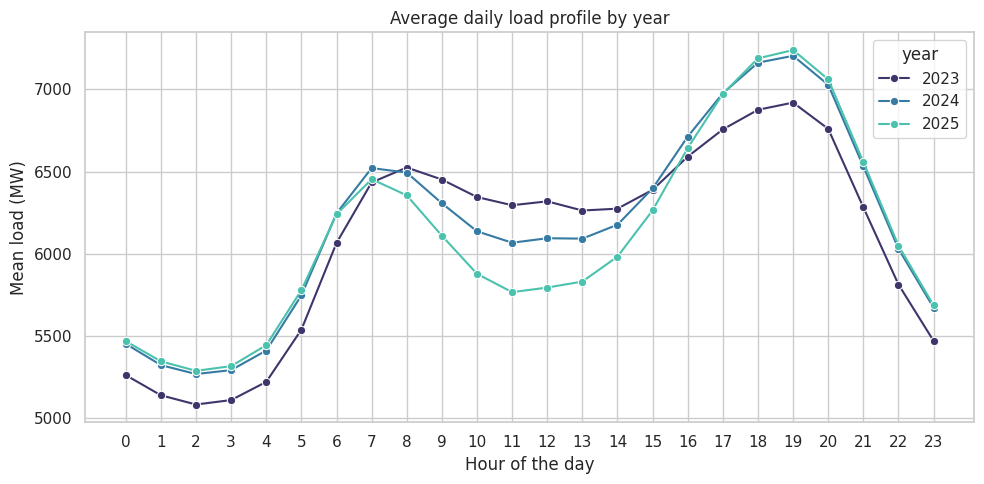

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

data = merged

load_col = "Actual Total Load (MW)"
if load_col not in data.columns:
    load_col = data.select_dtypes("number").columns[0]

plot_df = (
    data[[load_col]]
    .assign(year=data.index.year, hour = data.index.hour)
    .groupby(["year","hour"], as_index = False)[load_col]
    .mean()
)

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=plot_df["year"].nunique())

plt.figure(figsize=(10,5))
sns.lineplot(
    data=plot_df, x="hour", y=load_col, hue="year",
    marker="o", palette = palette
)
plt.xticks(range(0,24))
plt.xlabel("Hour of the day")
plt.ylabel("Mean load (MW)")
plt.title("Average daily load profile by year")
plt.tight_layout()
plt.show()

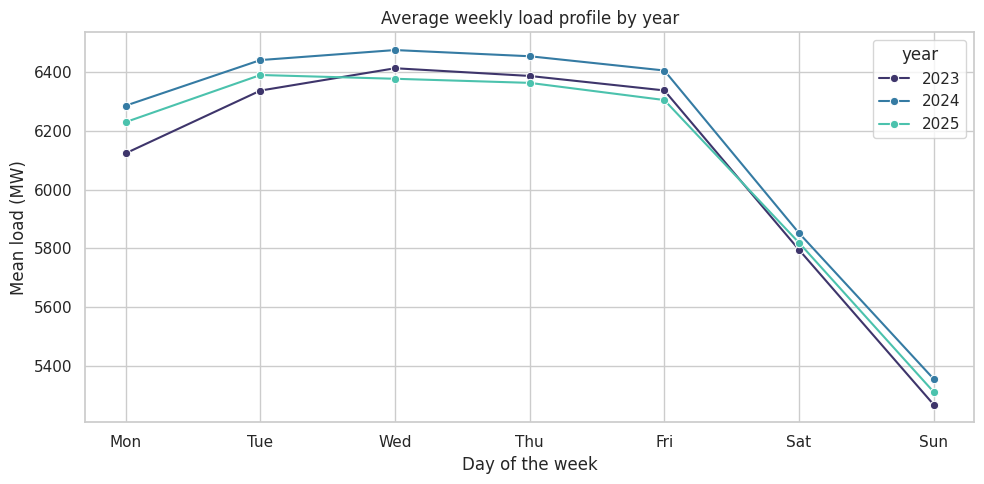

In [22]:
plot_df = (
    data[[load_col]]
    .assign(year=data.index.year, dow=data.index.dayofweek)
    .groupby(["year","dow"], as_index = False)[load_col]
    .mean()
)

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=plot_df["year"].nunique())

plt.figure(figsize=(10,5))
sns.lineplot(
    data=plot_df, x="dow", y=load_col, hue="year",
    marker="o", palette = palette
)
plt.xticks(range(0,7),
          labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
)

plt.xlabel("Day of the week")
plt.ylabel("Mean load (MW)")
plt.title("Average weekly load profile by year")
plt.tight_layout()
plt.show()

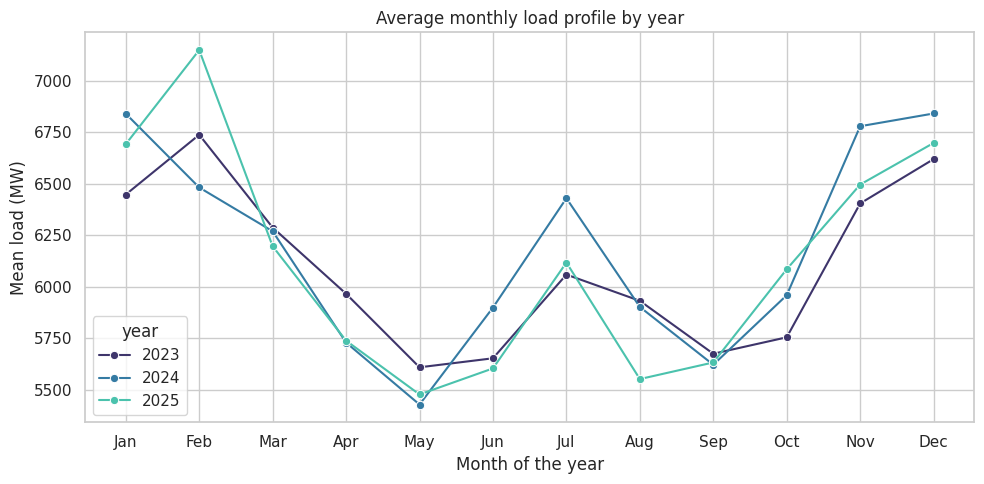

In [23]:
plot_df = (
    data[[load_col]]
    .assign(year=data.index.year, month=data.index.month)
    .groupby(["year","month"], as_index = False)[load_col]
    .mean()
)

sns.set_theme(style="whitegrid")
palette = sns.color_palette("mako", n_colors=plot_df["year"].nunique())

plt.figure(figsize=(10,5))
sns.lineplot(
    data=plot_df, x="month", y=load_col, hue="year",
    marker="o", palette = palette
)
plt.xticks(range(1,13),
          labels=["Jan","Feb","Mar","Apr","May","Jun",
            "Jul","Aug","Sep","Oct","Nov","Dec"]
)

plt.xlabel("Month of the year")
plt.ylabel("Mean load (MW)")
plt.title("Average monthly load profile by year")
plt.tight_layout()
plt.show()

#### Correlation between Electricity Load and Temperature

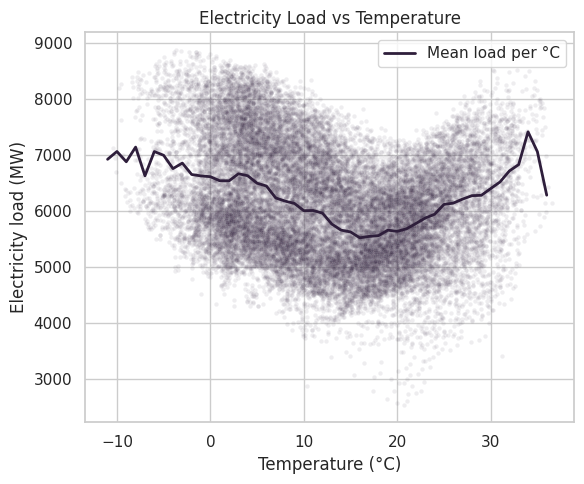

In [24]:
import numpy as np

data = merged.copy()
temp_col = "temp_c_avg"

data["temp_bin"] = np.floor(data[temp_col])

plot_df = (
    data
    .groupby("temp_bin", as_index = False)[load_col]
    .mean()
)

sns.set_theme(style="whitegrid", palette = "mako")

plt.figure(figsize=(6,5))
sns.scatterplot(
    data = data,
    x = temp_col,
    y = load_col,
    alpha=0.08,
    s=10
)

sns.lineplot(
    data=plot_df,
    x="temp_bin",
    y=load_col,
    linewidth=2,
    label="Mean load per °C"
)

plt.xlabel("Temperature (°C)")
plt.ylabel("Electricity load (MW)")
plt.title("Electricity Load vs Temperature")
plt.tight_layout()
plt.show()

In [25]:
pearson_corr = data[temp_col].corr(data[load_col], method="pearson")
print(f"Pearson correlation (temperature vs load): {pearson_corr:.3f}")

Pearson correlation (temperature vs load): -0.257


Correlation between electricity load and temperature seems to be non-linear, but follows a slight U-shape trend. In other words, electricity consumption seems high when temperatures are either hot or cold, but seems to drop down when temperatures are comfortable.
To further explore this hypothesis, correlation between electricity load and deviation from a comfort temperature of 18 is computed and plotted below.

In [26]:
comfort_temp = 18
data["temp_dev"] = (data[temp_col] - comfort_temp).abs()

pearson_dev = data["temp_dev"].corr(data[load_col],method = "pearson")
print(f"Pearson correlation (|temp - 18| vs load): {pearson_dev:.3f}")

Pearson correlation (|temp - 18| vs load): 0.405


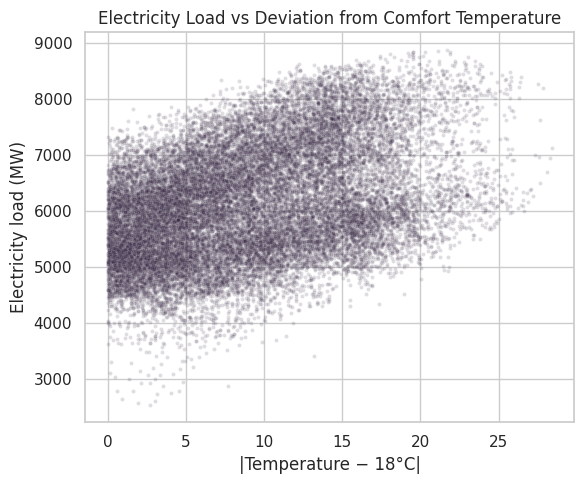

In [27]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=data,
    x="temp_dev",
    y=load_col,
    alpha=0.15,
    s=8
)

plt.xlabel("|Temperature − 18°C|")
plt.ylabel("Electricity load (MW)")
plt.title("Electricity Load vs Deviation from Comfort Temperature")
plt.tight_layout()
plt.show()

#### Autocorrelation Function of Electricity Load for Lag

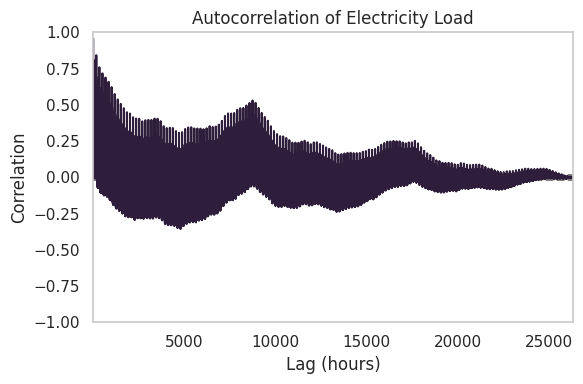

In [28]:
from pandas.plotting import autocorrelation_plot

data = merged.copy()

plt.figure(figsize=(6,4))
autocorrelation_plot(data[load_col])

plt.title("Autocorrelation of Electricity Load")
plt.xlabel("Lag (hours)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

**Interpretation:** 
- Very high correlation near lag 1 indicates that the electricity load changes smoothly and current load strongly depends on the previous hour.
- A slow decay of correlation can be observed, suggesting that the effect of past values on current ones stretches across a long backlog
- The slight wave pattern suggests that there is a periodicity to these values.

#### Heatmap: hours of the day vs day of the week

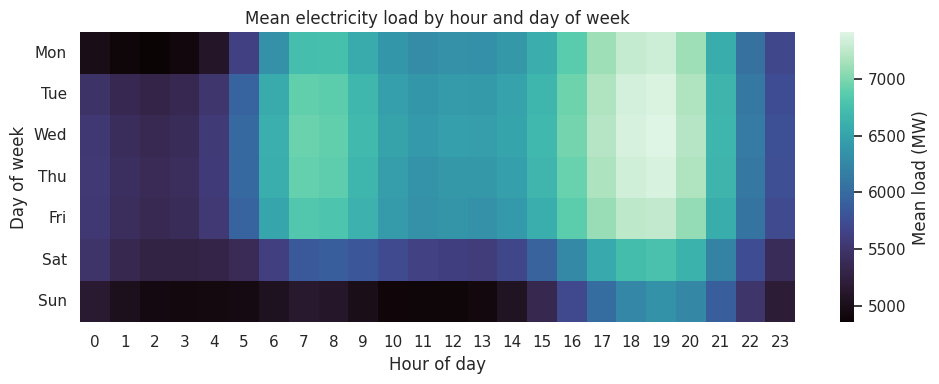

In [29]:
data = merged.copy()

heat_df = (
    data
    .assign(
        hour=data.index.hour,
        dow=data.index.dayofweek
    )
    .groupby(["dow","hour"],as_index=False)[load_col]
    .mean()
)

heat_pivot = heat_df.pivot(index="dow", columns="hour", values=load_col)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,4))

sns.heatmap(
    heat_pivot,
    cmap="mako",
    cbar_kws={"label":"Mean load (MW)"}
)

plt.yticks(
    ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5],
    labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"],
    rotation=0
)

plt.xlabel("Hour of day")
plt.ylabel("Day of week")
plt.title("Mean electricity load by hour and day of week")
plt.tight_layout()
plt.show()

**Interpretation** : Hourly patterns seem consistent across the week, with:
- very low electrictiy consumption during Saturday and Sunday at allmost all hours of the day (except for the 17:00-20:00 time interval)
- very low consumptions on all days during the interval 00:00-04:00
- moderate consumption during the middle of the day and high consumption in the morning and evening, during week hours (with a slight reduction on Friday).

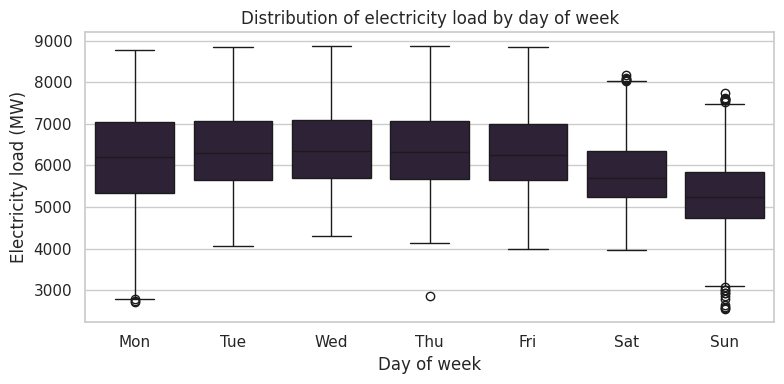

In [30]:
data = merged.copy()
data["dow"] = data.index.dayofweek

sns.set_theme(style="whitegrid", palette="mako")
plt.figure(figsize=(8,4))

sns.boxplot(
    data=data,
    x="dow",
    y=load_col
)

plt.xticks(
    ticks=range(7),
    labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
)
plt.xlabel("Day of week")
plt.ylabel("Electricity load (MW)")
plt.title("Distribution of electricity load by day of week")
plt.tight_layout()
plt.show()

In [31]:
Q1 = data[load_col].quantile(0.25)
Q3 = data[load_col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[
    (data[load_col] < lower_bound) |
    (data[load_col] > upper_bound)
]

outliers_info = outliers[[load_col, temp_col, "dow"]].copy()
outliers_info["date"] = outliers_info.index
print(outliers_info.sort_values(load_col, ascending=False).head(10))


                     Actual Total Load (MW)  temp_c_avg  dow  \
2024-05-05 15:00:00                 3208.50   20.914286    6   
2024-05-06 13:00:00                 3174.50   22.628571    0   
2024-05-06 10:00:00                 3142.25   20.071429    0   
2024-05-05 10:00:00                 3109.00   18.157143    6   
2024-05-06 12:00:00                 3092.00   22.171429    0   
2025-04-20 09:00:00                 3077.50   15.400000    6   
2024-05-06 11:00:00                 3067.25   21.342857    0   
2025-04-21 09:00:00                 3046.00   17.557143    0   
2024-05-05 14:00:00                 3011.75   21.014286    6   
2024-05-05 11:00:00                 2998.25   19.385714    6   

                                   date  
2024-05-05 15:00:00 2024-05-05 15:00:00  
2024-05-06 13:00:00 2024-05-06 13:00:00  
2024-05-06 10:00:00 2024-05-06 10:00:00  
2024-05-05 10:00:00 2024-05-05 10:00:00  
2024-05-06 12:00:00 2024-05-06 12:00:00  
2025-04-20 09:00:00 2025-04-20 09:00:00  
2

**Interpretation** Some of these outliers correspond to national Romanian holidays: May 5 and 6, 2025 were Othodox Easter Sunday and Monday respectively. Similarly for April 20 and 21, 2025.

### Feature Engineering
Proposed **features**, given an **hour t**: 
**Lag features** 
- load(t-1),...,load(t-24)
- load(t-168) (same hour last week)

**Operator's Forecast:** F(t) (operator's forecast for hour t, **Day-ahead Total Load Forecast (MW)**)

**Cyclical features:**
- hour of the day
  - hour_sin = sin(2$\pi \times$ hour / 24) (to better capture the cyclical nature of the hours, e.g. 23:00 and 00:00 are closer than a linear representation would otherwise suggest)
  - hour_cos = cos(2$\pi \times$ hour / 24) \
Similarly:
- day of the week:
  - dow_sin = sin(2$\pi \times$ day_of_week / 7)
  - dow_cos = cos(2$\pi \times$ day_of_week / 7)
- month
  - month_sin = sin(2$\pi \times$ month/ 12)
  - month_cos = cos(2$\pi \times$ month / 12)

**Differences**
- $\Delta_{1}$ = load(t-1) - load(t-2)
- $\Delta_{24}$ = load(t-1) - load(t-25)

**Deviation from Comfort Temperature** \
temp_dev(t-1) = | Temperature(t-1) − 18 |

**Target**: A(t) (**Actual Total Load (MW)**)

In [32]:
data = merged.copy()
data = data.rename(columns={
    "Actual Total Load (MW)": "load",
    "Day-ahead Total Load Forecast (MW)": "forecast",
    "temp_c_avg": "temp"
})

# Calendar features
data["hour"] = data.index.hour
data["day_of_week"] = data.index.dayofweek
data["month"] = data.index.month

# Cyclical encodings
data["hour_sin"]= np.sin(2*np.pi*data["hour"] /24)
data["hour_cos"]= np.cos(2*np.pi*data["hour"] /24)

data["dow_sin"]= np.sin(2*np.pi*data["day_of_week"] /7)
data["dow_cos"]= np.cos(2*np.pi*data["day_of_week"] /7)

data["month_sin"]= np.sin(2*np.pi*data["month"] /12)
data["month_cos"]= np.cos(2*np.pi*data["month"] /12)

# Lag Features
for lag in range(1,25):
    data[f"lag_{lag}"] = data["load"].shift(lag)

# Same hour last week
data["lag_168"] = data["load"].shift(168)

# Difference features
data["delta_1"] = data["load"].shift(1) - data["load"].shift(2)
data["delta_24"] = data["load"].shift(1) - data["load"].shift(25)

# Temperature feature
data["temp_dev_lag1"] = (data["temp"].shift(1) - 18).abs()

# Target
data["target"] = data["load"]

# Only keep rows with full history
data = data.dropna()

# Final feature set
feature_cols = (
    [f"lag_{i}" for i in range (1,25)] +
    ["lag_168", "forecast",
     "hour_sin", "hour_cos",
     "dow_sin", "dow_cos",
     "month_sin", "month_cos",
     "delta_1", "delta_24",
     "temp_dev_lag1"]
)

X = data[feature_cols]
y = data["target"]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (26130, 35)
Target vector shape: (26130,)


### Train/Test Split

In [33]:
train_mask = X.index < "2025-01-01"
test_mask = X.index >= "2025-01-01"

X_train = X.loc[train_mask]
X_test = X.loc[test_mask]

y_train = y.loc[train_mask]
y_test = y.loc[test_mask]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (17374, 35) (17374,)
Test shape: (8756, 35) (8756,)


### Model training and evaluation

Baseline: Day-ahead Total Load Forecast (MW)

Evaluation: MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error)

In [34]:
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baseline: operator's forecast as-is
y_pred_op = X_test["forecast"]

# Evaluate baseline with MAE and RMSE
mae_op = mean_absolute_error(y_test, y_pred_op)
rmse_op = np.sqrt(mean_squared_error(y_test, y_pred_op))

print("Operator forecast baseline")
print("MAE: ", mae_op)
print("RMSE: ", rmse_op)

Operator forecast baseline
MAE:  122.28787184026193
RMSE:  177.19810112896496


### Gradient-boosted decision tree model
- an ensemble of many small decision trees in which each subsequent tree learns to predict the errors (residuals) of the trees before it
- the final prediction is the sum of all trees' outputs, weighted by a learning rate
**HistGradientBoostingRegressor:**
- histogram-based, it does not split on raw continuous values. Instead, it discretizes each feature into bins and learns to split on those, rather than on exact values.
- This results in much faster training on large datasets and less sensitivity to noise in continuous values.
- It is a suitable choice for this dataset because gradient-boosted decision trees naturally capture nonlinear relationships and behave well on tabular data.

In [35]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Model
gbr = HistGradientBoostingRegressor(
    random_state=13,
    learning_rate=0.05,
    max_depth=8,
    max_iter=800
)

# Fitting
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# Evaluating
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print("Gradient Boosting (HistGradientBoostingRegressor)")
print("MAE:", mae_gbr)
print("RMSE:", rmse_gbr)                                    

Gradient Boosting (HistGradientBoostingRegressor)
MAE: 64.97422846092108
RMSE: 90.86642730305192


### SHAP (SHapley Additive exPlanations)

/home/maia-marin/venvs/jupyter-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 8727/8756 [01:39<00:00]        

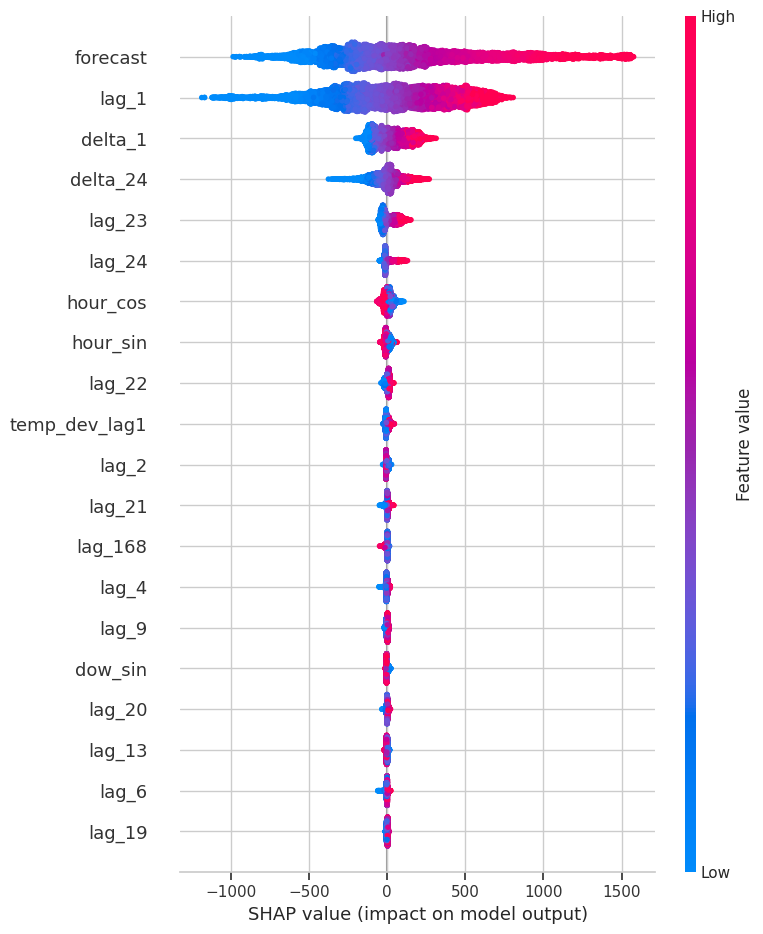

In [36]:
import shap

X_shap_bg = X_train.sample(1000, random_state=13)

explainer = shap.Explainer(gbr, X_shap_bg)

shap_values = explainer(X_test, check_additivity=False)

shap.summary_plot(shap_values, X_test, show=True)

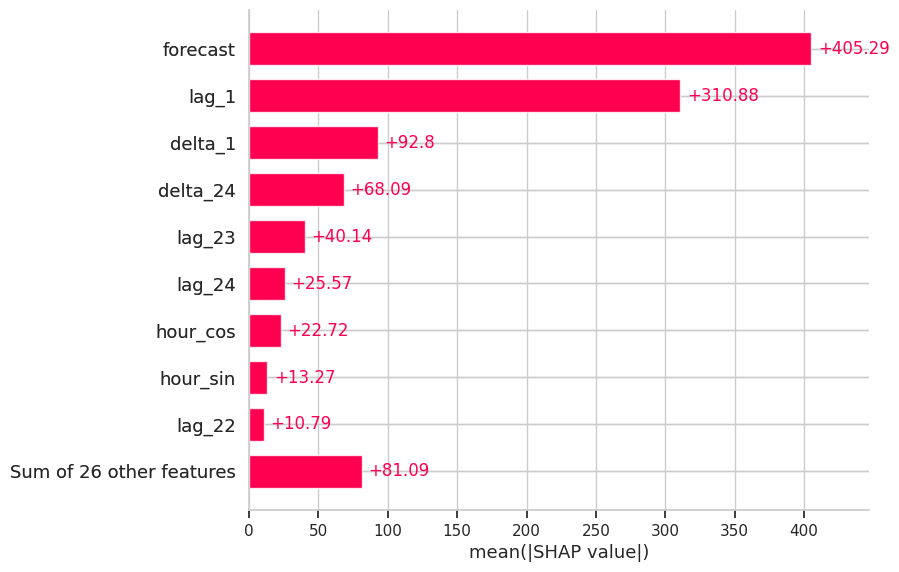

In [37]:
shap.plots.bar(shap_values)

**Interpretation:** The model leverages the operator's forecast, but corrects it using other signals such as:
- lag_1 and delta_1, indicating the most recent load history entry and the difference between it and the current time
- lag_23, lag_24, lag_22 and delta_24, showing that the same hour the day prior together with the values around it are amongst the strongest indicators
- hour_cos and hour_sin contribute, even if not massively
- temp_dev_lag1 has an effect (it is placed just under lag_22), but it is not pronounced.